In [24]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from scipy import signal
from matplotlib import cm

### Эксперимент 1(звуковой генератор и осицллограф)

##### Интерполяция экспериментальных данных

In [6]:
data_tonnel = pd.read_csv('tonnel_scope.csv')
x_v_scale, y_v_scale = 0.1, 0.1 #вольт на деление
data_tonnel['x_v'], data_tonnel['y_v'] = x_v_scale * data_tonnel.x, y_v_scale * data_tonnel.y
data_tonnel['u'] = -data_tonnel['x_v'] 
data_tonnel['u'] += np.abs(np.min(data_tonnel['u']))
data_tonnel['y_v'] += np.abs(np.min(data_tonnel['y_v']))

In [7]:
def non_tonnel_current(x, A, B):
    return np.exp(x * B) * A
def tunnel_current(x, D, E):
    return np.power(x, 2) * D * np.exp(- np.power(x, 2) * E)
def line_func(x, alpha, beta):
    return alpha * x + beta
def interp_func(x, A, B, D, E, alpha, beta):
    return non_tonnel_current(x, A, B) + tunnel_current(x, D, E) + line_func(x, alpha, beta)

In [8]:
mask_1 = data_tonnel.u < 0.425
df_1 = data_tonnel.values[mask_1] 
df_2 = data_tonnel.values[-mask_1][::2]
print(df_2.shape)
print(df_1.shape)
print(type(df_1))
data_tonnel_2 = pd.DataFrame()
for key, arr in zip(data_tonnel.keys(), np.concatenate([df_1, df_2]).T):
    data_tonnel_2[key] = arr

(15, 5)
(15, 5)
<class 'numpy.ndarray'>


In [9]:
param, _  = opt.curve_fit(f = interp_func, 
                          xdata = data_tonnel_2.u, 
                          ydata = data_tonnel_2.y_v, 
                          maxfev = int(1e4),
                          p0 = [1, 6, 0.1, 1, -2, 0])
x_line = np.linspace(0, 0.6, 10000)
y_interp = interp_func(x_line, *param)
print(param.round(2))

/home/vladimir/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[ 0.0000e+00  3.3430e+01  5.4231e+02  7.3184e+02 -1.3000e-01  4.0000e-02]


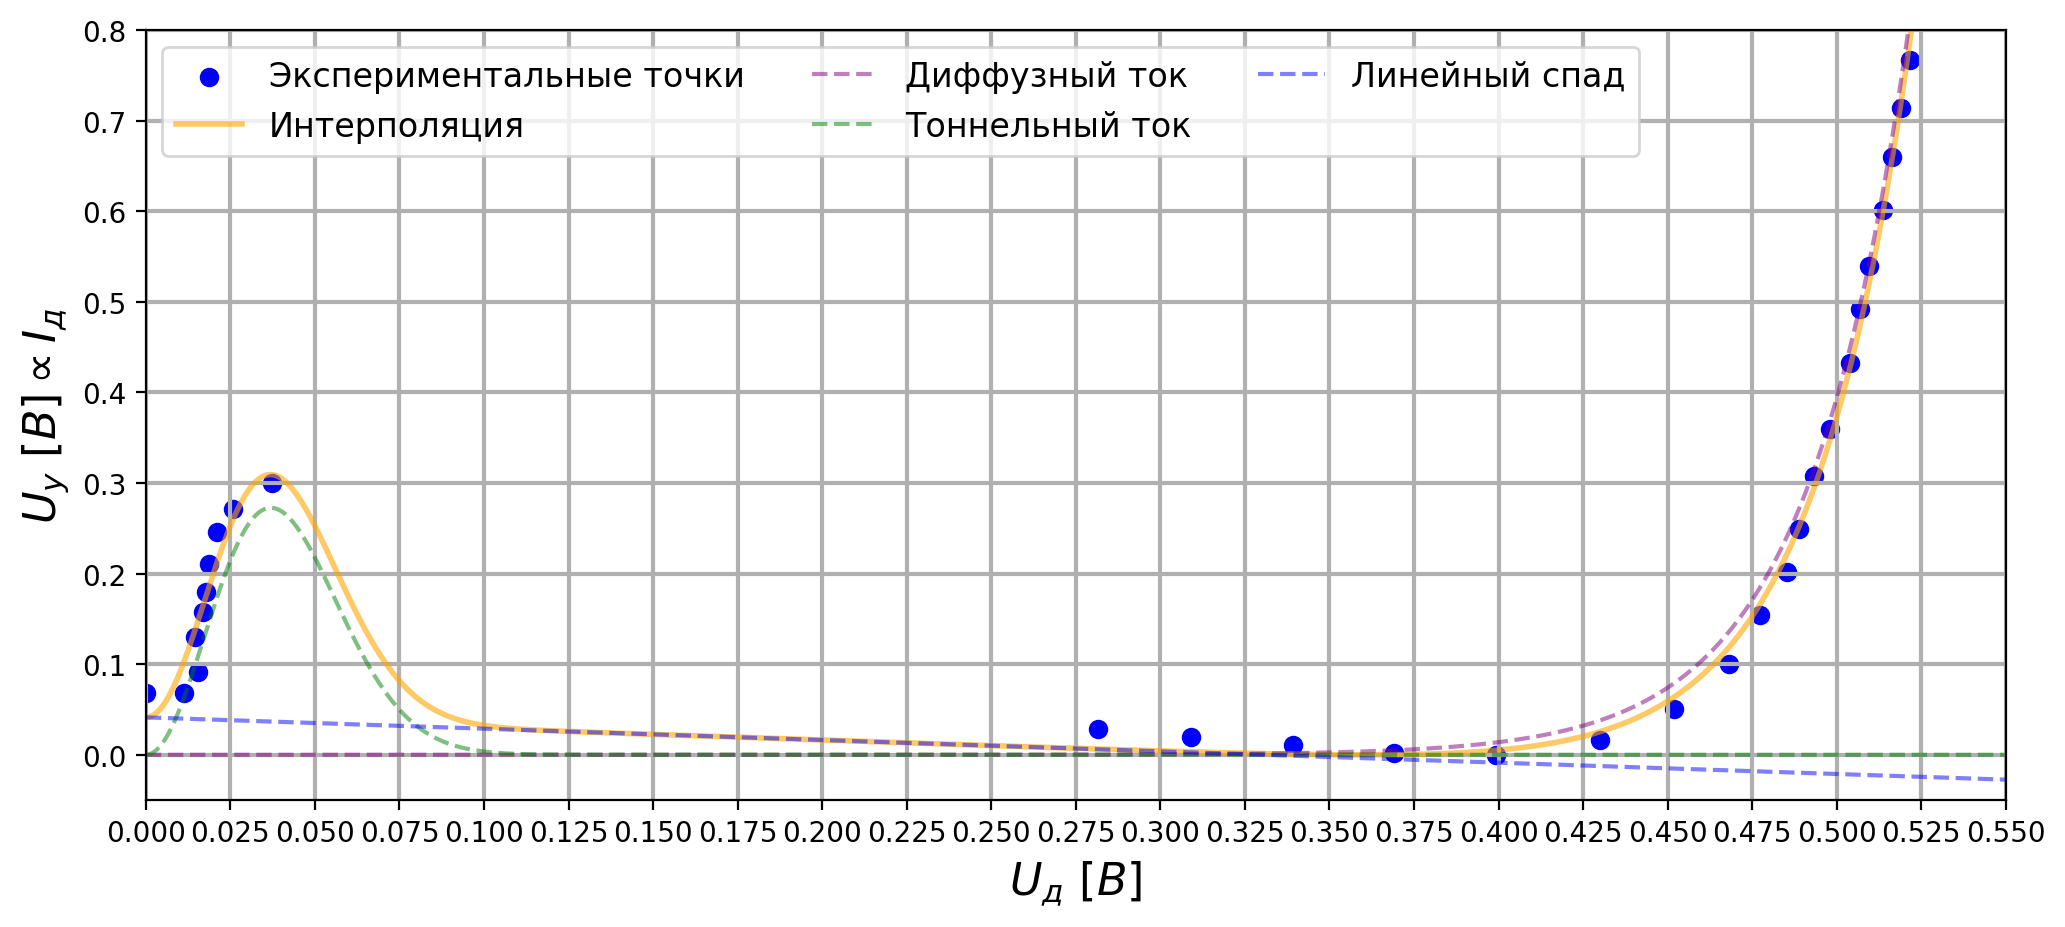

In [10]:
plt.figure(figsize = (12, 5), dpi  = 200)
plt.scatter(data_tonnel_2.u, data_tonnel_2.y_v, label = 'Экспериментальные точки', color = 'blue')
plt.xticks(np.arange(0, 0.8, 0.025))
plt.plot(x_line, y_interp, color = 'orange', label = 'Интерполяция', linewidth = 2, alpha = 0.6)
plt.plot(x_line, non_tonnel_current(x_line, *param[:2]), linestyle = '--', label = 'Диффузный ток',  alpha = 0.5, color = 'purple')
plt.plot(x_line, tunnel_current(x_line, *param[2:4]), linestyle = '--', label = 'Тоннельный ток',  alpha = 0.5, color = 'green')
plt.plot(x_line, line_func(x_line, *param[4:]), linestyle = '--', label = 'Линейный спад', alpha = 0.5, color = 'blue')
plt.grid(which = 'major', linewidth = 1.5)
plt.xlim(0, 0.55)
plt.ylim(-0.05, 0.8)
plt.xlabel("$U_{д} \ [В]$", fontsize = 16)
plt.ylabel("$U_{y} \ [В] \propto I_{д}$", fontsize = 16)
plt.legend(fontsize = 12, ncols = 3)

##### Нахождение параметров $U_{p}$, $U_{v}$, $U_{f}$.

- $U_p$ - `argmax зеленой кривой`
- $U_v$ - `argmin общей интерполяции`
- $U_{f}$ - положение где фиолетовая кривая достигает значения максимума зеленой кривой 

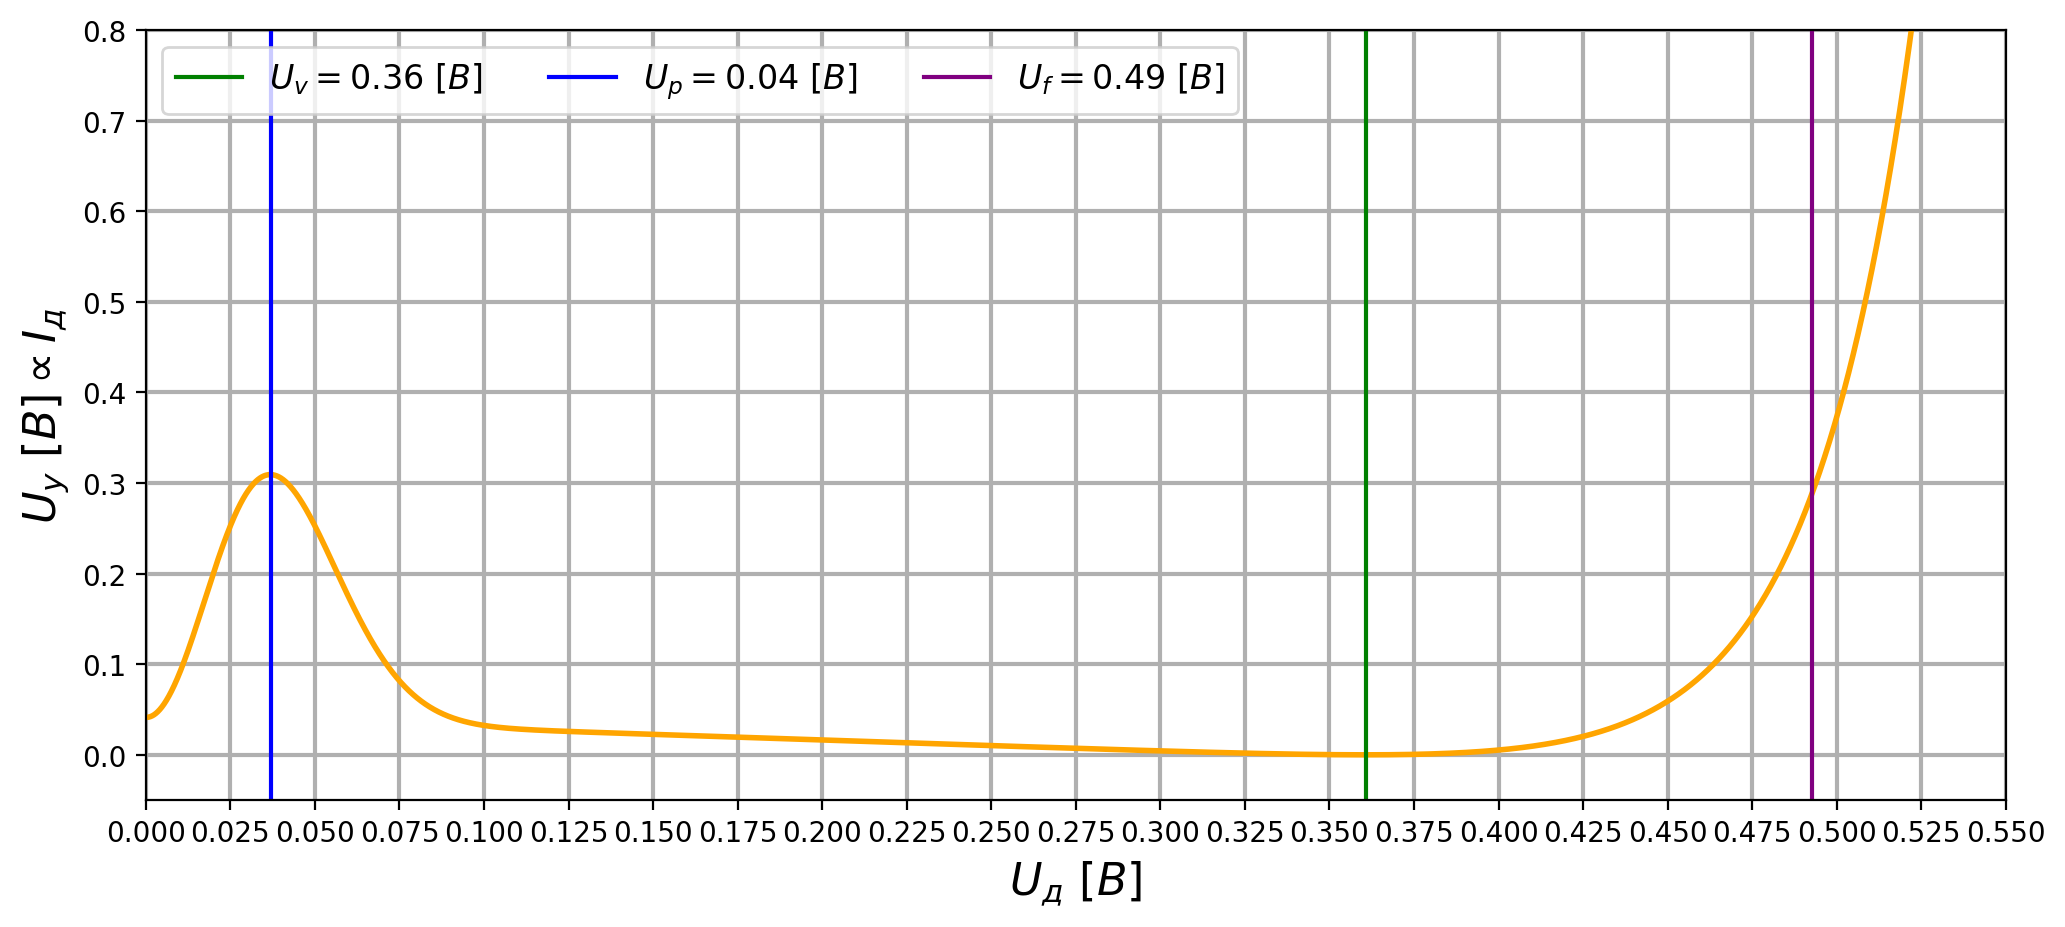

In [11]:
mask = x_line < 0.1
tunnel_max = np.max(interp_func(x_line, *param)[mask])
U_p = x_line[np.argmax(tunnel_current(x_line, *param[2:4]))]
U_v = x_line[np.argmin(y_interp)] 
U_f = x_line[np.argmin(np.abs(non_tonnel_current(x_line, *param[:2]) - tunnel_max))]

plt.figure(figsize = (12, 5), dpi  = 200)
plt.xticks(np.arange(0, 0.8, 0.025))
plt.plot(x_line, y_interp, color = 'orange', linewidth = 2)
plt.axvline(U_v, label = f'$U_v = {U_v:.2f} \ [В]$', color = 'green')
plt.axvline(U_p, label = f'$U_p = {U_p:.2f} \ [В]$', color = 'blue')
plt.axvline(U_f, label = f'$U_f = {U_f:.2f} \ [В]$', color = 'purple')
plt.grid(which = 'major', linewidth = 1.5)
plt.xlim(0, 0.55)
plt.ylim(-0.05, 0.8)
plt.xlabel("$U_{д} \ [В]$", fontsize = 16)
plt.ylabel("$U_{y} \ [В] \propto I_{д}$", fontsize = 16)
plt.legend(fontsize = 12, ncols = 3)

### Эксперимент 2

In [12]:
def non_tonnel_current(x, A, B):
    return np.exp(x * B) * A
def tunnel_current(x, D, E):
    return np.power(x, 2) * D * np.exp(- np.power(x, 2) * E)
def line_func(x, alpha, beta):
    return alpha * x + beta
def interp_func(x, A, B, D, E, alpha, beta):
    return non_tonnel_current(x, A, B) + tunnel_current(x, D, E) + line_func(x, alpha, beta)

(0.0, 0.5)

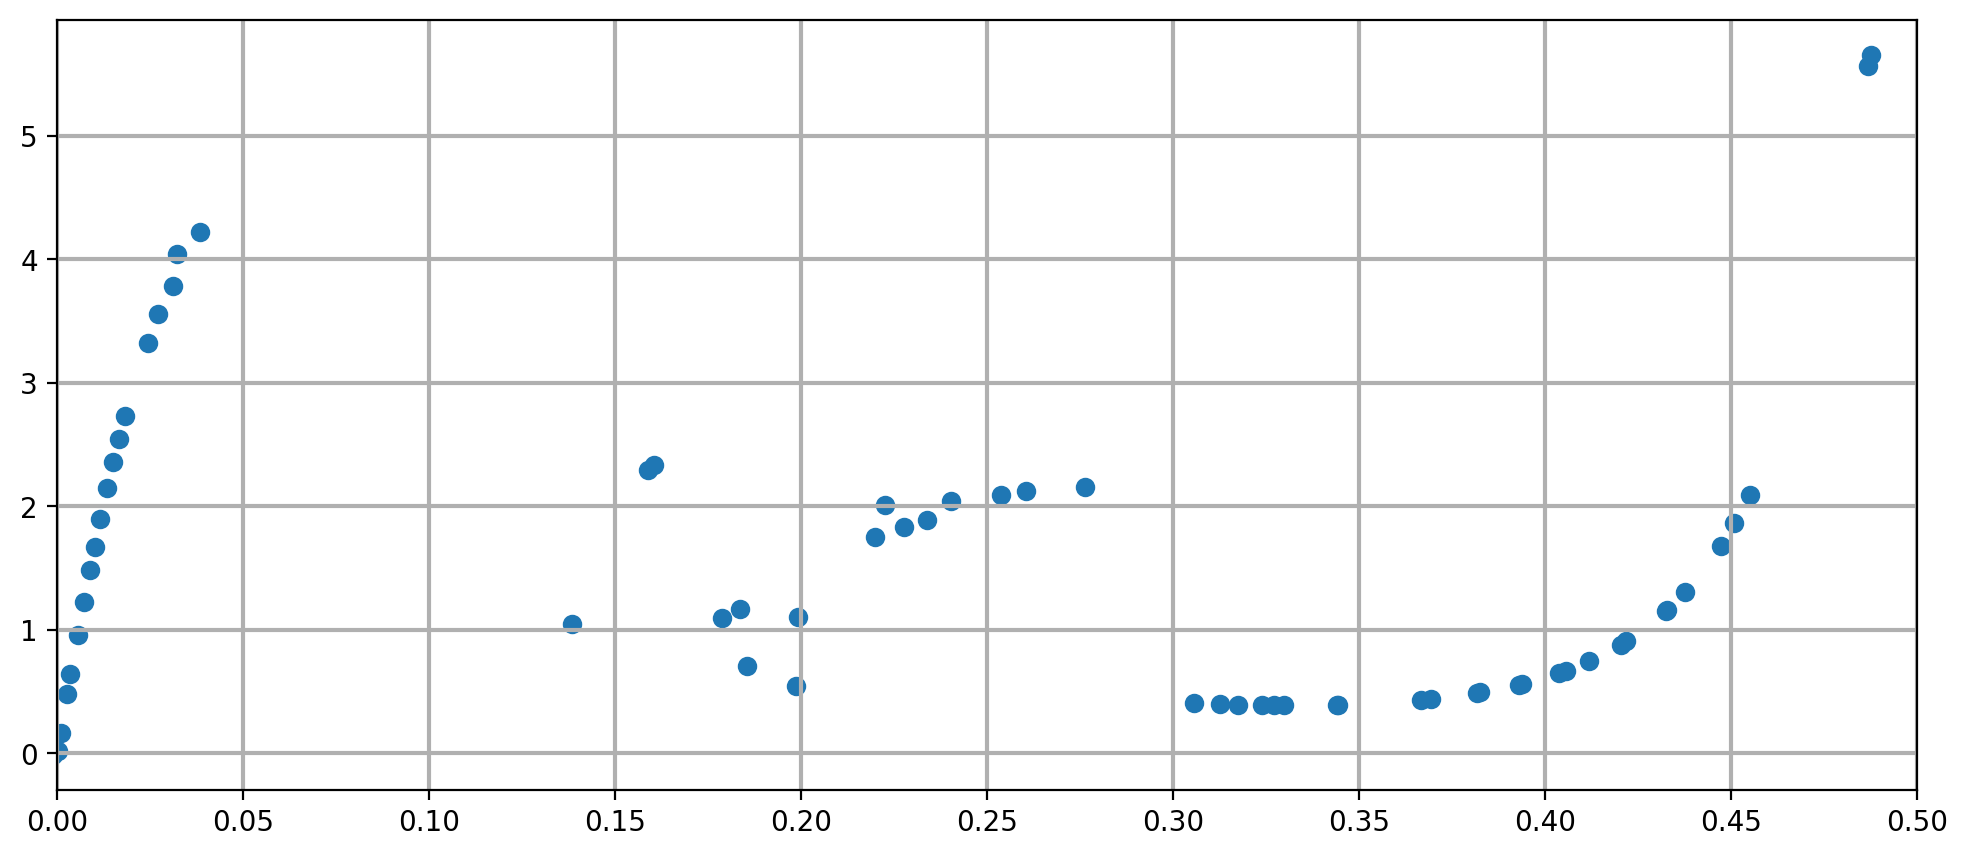

In [13]:
plt.figure(figsize = (12, 5), dpi = 200)
data = pd.read_csv("vah.csv")
plt.scatter(data.U, data.I)
plt.xticks(np.arange(0, 0.55, 0.05))
plt.grid(which = 'major', linewidth = 1.5)
plt.xlim(0, 0.5)

In [14]:
param, _  = opt.curve_fit(f = interp_func, 
                          xdata = data.U, 
                          ydata = data.I, 
                          maxfev = int(1e4),
                          p0 = [0.0000e+00, 3.3430e+01, 5.4231e+02, 7.3184e+02, -1.3000e-01, 4.0000e-02])
x_line = np.linspace(0, 0.6, 10000)
y_interp = interp_func(x_line, *param)

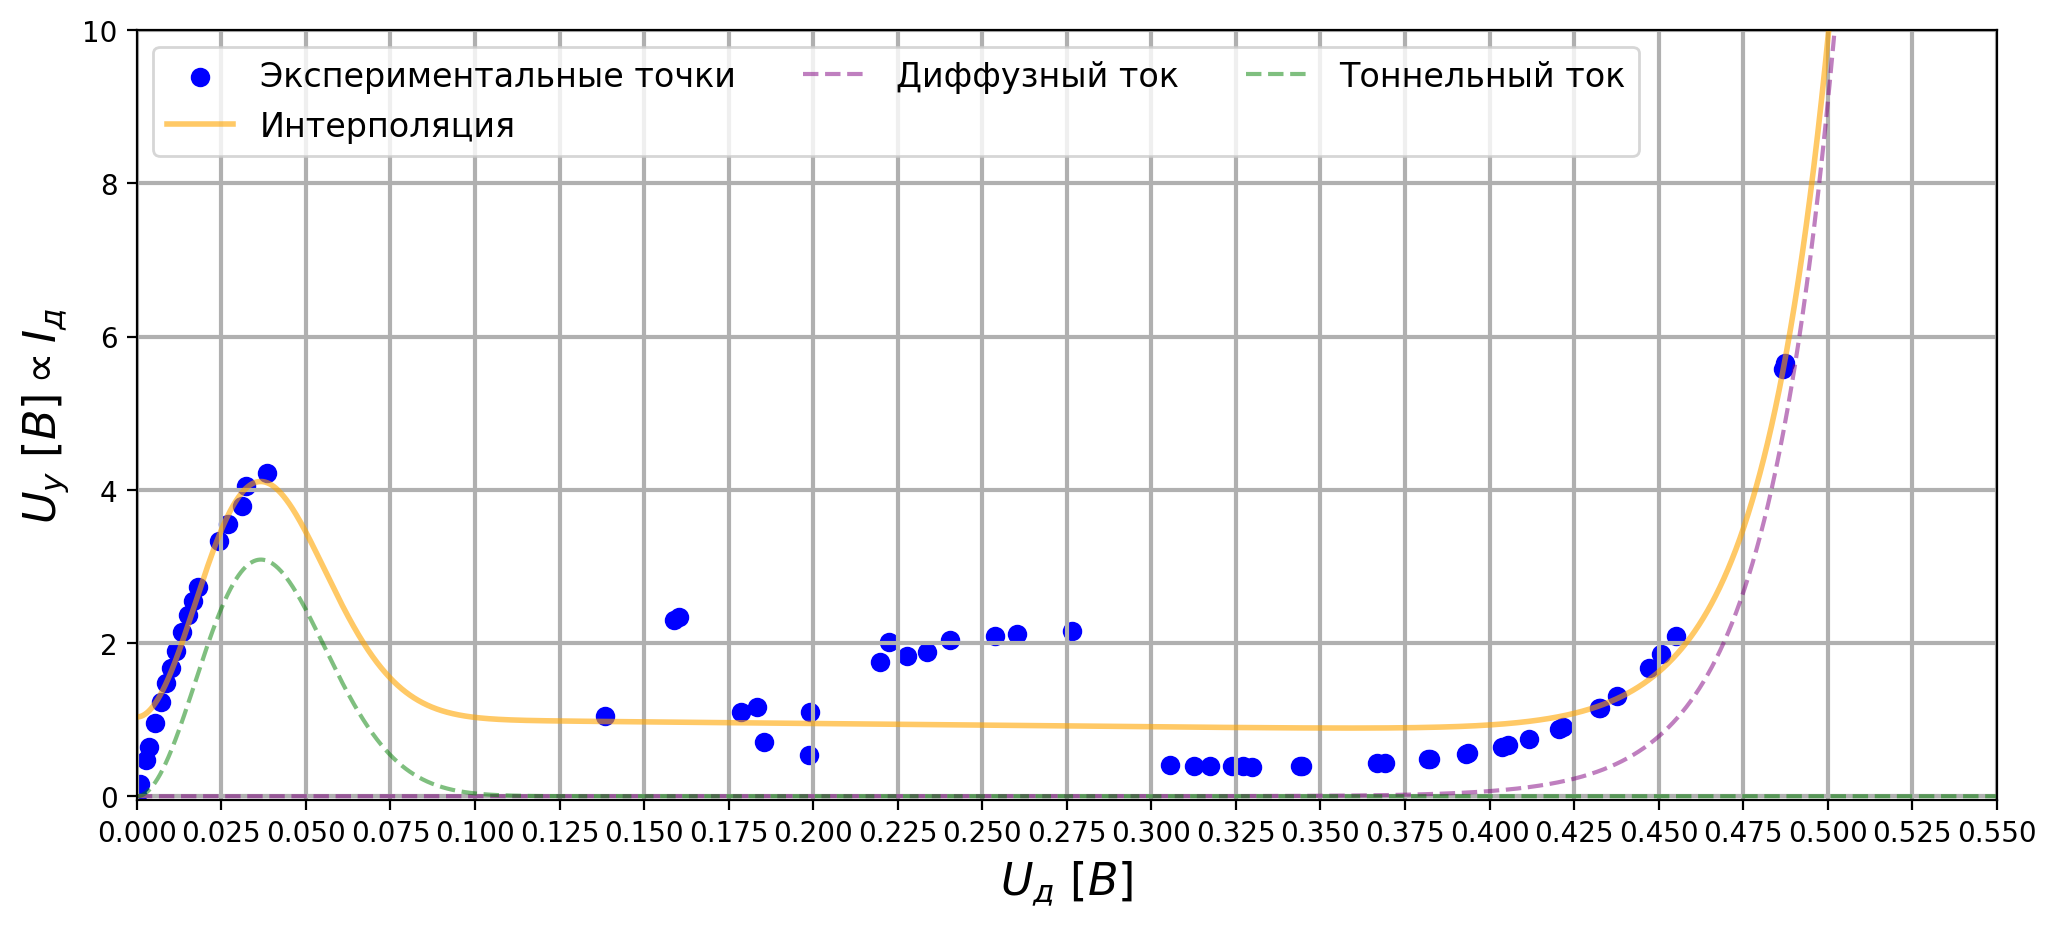

In [15]:
plt.figure(figsize = (12, 5), dpi  = 200)
plt.scatter(data.U, data.I, label = 'Экспериментальные точки', color = 'blue')
plt.xticks(np.arange(0, 0.8, 0.025))
plt.plot(x_line, y_interp, color = 'orange', label = 'Интерполяция', linewidth = 2, alpha = 0.6)
plt.plot(x_line, non_tonnel_current(x_line, *param[:2]), linestyle = '--', label = 'Диффузный ток',  alpha = 0.5, color = 'purple')
plt.plot(x_line, tunnel_current(x_line, *param[2:4]), linestyle = '--', label = 'Тоннельный ток',  alpha = 0.5, color = 'green')

plt.grid(which = 'major', linewidth = 1.5)
plt.xlim(0, 0.55)
plt.ylim(-0.05, 10)
plt.xlabel("$U_{д} \ [В]$", fontsize = 16)
plt.ylabel("$U_{y} \ [В] \propto I_{д}$", fontsize = 16)
plt.legend(fontsize = 12, ncols = 3)

### Эксперимент 3 - осциллятор на диоде

In [16]:
from os import walk

filenames = next(walk(r"experiment_3_oscillograms"), (None, None, []))[2]
print(filenames)

['2.csv', '1.csv', '6.csv', '3.csv', '4.csv']


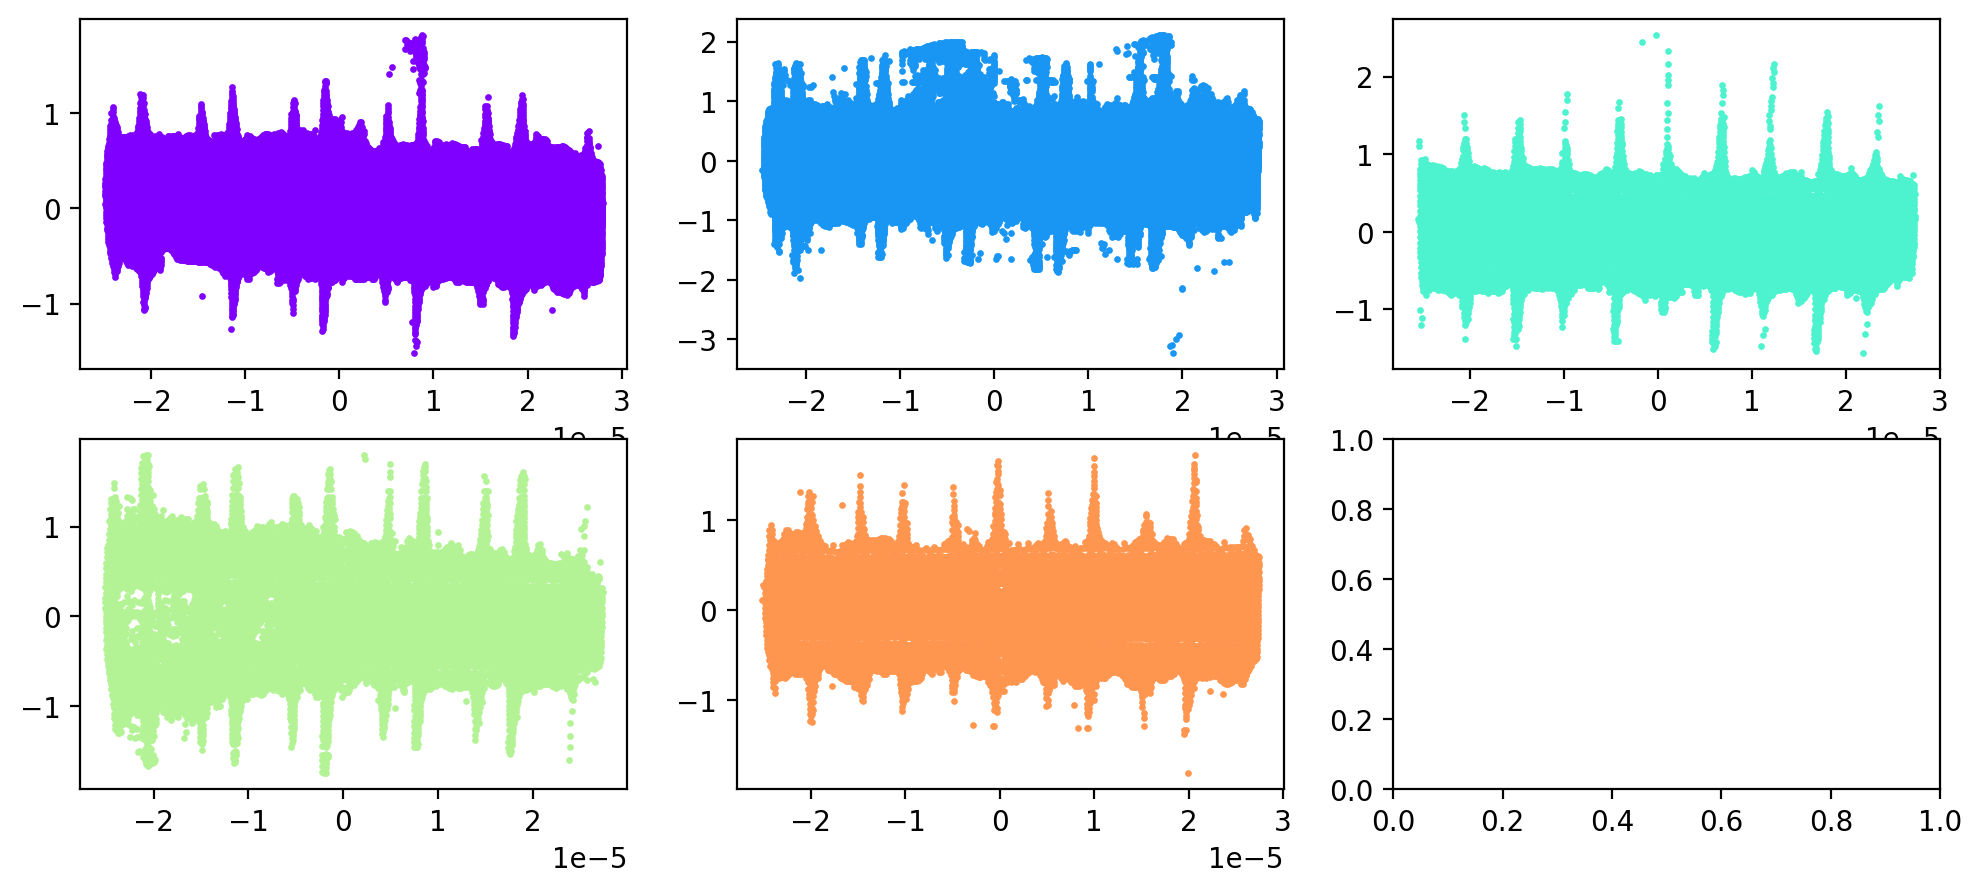

In [37]:
fig, ax = plt.subplots(2, 3,figsize = (12, 5), dpi = 200)

for filename, plotable, color in zip(filenames, ax.ravel(), cm.rainbow(np.arange(len(filenames)) / len(filenames))):
    data = pd.read_csv(f"experiment_3_oscillograms/{filename}")
    data.x *= 5 * 1e-6
    data.y -= np.mean(data.y)
    plotable.scatter(data.x, data.y, s = 2, color = color)
